# Example `KM-GP` network application to mock time series data 

Let's demonstrate how to use the `KM-GP` network in the `bants` class on a simple mock example. First we need to import `bants` and other modules to make the mock data and do some plotting...

In [1]:
import sys
path = '/Users/Rob/work/bants/' # Give your path to bants here
sys.path.append(path + 'source/')
from bants import bants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Now we generate some mock time series data using a random degenerate Langevin system...

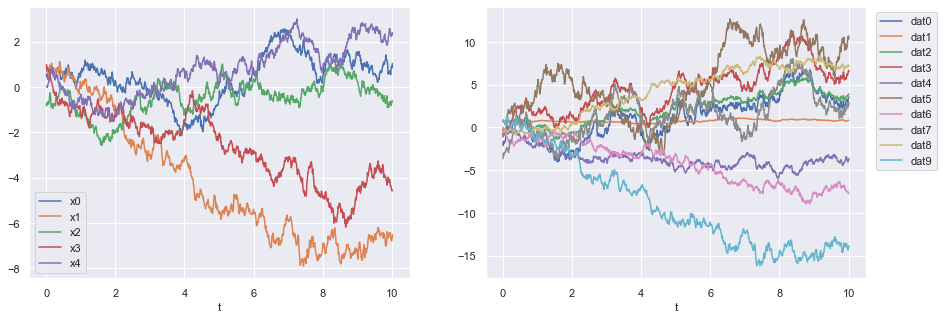

In [2]:
# Evolve the n-d Langevin system
def L_syst_gen(n,runtime,stepsize):    
    # Specify simple drift function with random linear couplings
    def f(x):
        a = np.random.normal(0.0,1.0,size=len(x))
        b = np.random.normal(0.0,1.0,size=len(x))
        return a*x + b*x[np.random.randint(0,len(x),size=len(x))]    
    # Initialise process and run
    t, x = 0.0, np.random.normal(0.0,1.0,size=n)
    out_store = [] 
    while t < runtime:
        t += stepsize
        x += -(stepsize*f(x))+(np.sqrt(stepsize)*np.random.normal(0.0,1.0,size=n))
        out_store.append(np.append(t,x))        
    # Output time series as a pandas dataframe
    out_df = pd.DataFrame(np.asarray(out_store),columns=['t']+['x'+str(ni) for ni in range(0,n)]).set_index('t')
    return out_df
# Choose number of dimensions, total runtime and stepsize
n = 5
runtime = 10.0
stepsize = 0.01
# Run Langevin system and plot output
df = L_syst_gen(n,runtime,stepsize)
# Now add dimensions by creating arbitrary combinations 
# of each column to create a mock degenerate dataset
ndatadim = 10
for i in range(0,ndatadim):
    coeff = np.random.normal(0.0,1.0,size=n)
    power = np.random.randint(0,2,size=n)
    df['dat'+str(i)] = 0.0
    for j in range(0,n):
        df['dat'+str(i)] += coeff[j] * (df['x'+str(j)] ** power[j])
df_comp = df[['x'+str(i) for i in range(0,n)]]
df = df[['dat'+str(i) for i in range(0,ndatadim)]]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df_comp.plot(ax=ax[0])
df.plot(ax=ax[1])
ax[1].legend(bbox_to_anchor=(1.2,1.0))
plt.show()

Let's first apply differencing to the data as a pre-processing step...

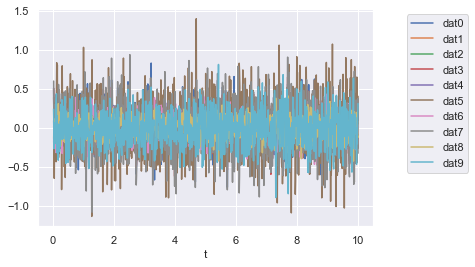

In [3]:
ddf = df.diff().iloc[1:]
ddf.plot()
plt.legend(bbox_to_anchor=(1.3,1.0))
plt.show()

The `bants` class works in the same pattern as a `scikit-learn` estimator. We initialise `bants('KM-GP')` and fit with the `bants.fit` method to the differenced dataframe with the in-built optimiser methods...

/Users/Rob/work/bants/source/bants.py:99: RuntimeWarning: invalid value encountered in log
  - (0.5 * np.log(np.linalg.det(Sigma)))


Best fit hyperparameters are: {'itmax': 10000, 'lnEtol': 0.0001, 'learn_rate': 0.001, 'kmeans_nclus': 5, 'kmeans_max_iter': 10, 'kmeans_random_state': 42, 'nu': 10, 'u': array([ 5.61357880e-03,  7.45230891e-07,  5.15903162e-03,  7.14694091e-05,
       -1.16111677e-05, -2.79475197e-03, -7.66918511e-03, -2.06383955e-03,
        2.53042949e-03, -1.72539583e-02]), 'U_flat': array([ 1.10965964e-02,  4.15260864e-03, -2.03299959e-03, -4.54163466e-03,
       -2.35663018e-02, -3.88413944e-01,  1.50000604e-01,  2.10639637e-02,
        1.29461956e-02,  5.35728099e-02, -8.25869899e-04, -3.01508000e-02,
        3.05278189e-03,  6.02612038e-02, -6.92872334e-02, -1.66127010e-01,
        1.66076458e-05,  3.27695068e-01,  2.77825831e-03,  3.91700454e-03,
        2.20799762e-02, -1.03836752e-02, -8.66167851e-03, -9.49447325e-02,
        9.23204033e-02, -2.35540423e-01,  8.27454174e-06,  1.98991222e-02,
        6.64557608e-03,  1.31409577e-01,  2.33586027e-01,  3.66573084e-02,
        1.21391130e-01,  1.

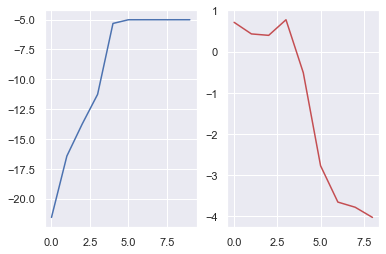

In [27]:
# Initialise class with 'KM-GP' network type (subsequently comment out if iterative runs of the cell are desired)
bts = bants('KM-GP')
# Set the maximum number of algorithm iterations per fitting run and the optimiser - it 
# works quite well to start with 'GD' then finish off with 'Nelder-Mead' nearer the optimum
bts.optimiser = 'GD' # 'Nelder-Mead'
bts.params['learn_rate'] = 0.001 # Only relevant for 'GD'
bts.params['itmax'] = 1000
bts.params['kmeans_nclus'] = n
bts.params['kmeans_max_iter'] = 10
bts.params['kmeans_random_state'] = 42
nfunc_eval = 0
lnE_vals = []
for i in range(0,10):
    # Apply 'fit' method on the training dataframe to optimise Bayesian network hyperparameters where
    # standardisation of the training data is automatically performed unless the keyword standard=False
    bts.fit(ddf)
    # Update initial parameter values for next run
    bts.u_guess = bts.params['u']
    bts.U_flat_guess = bts.params['U_flat']
    bts.Psi_tril_guess = bts.params['Psi_tril']
    # Store the log-evidence values from the run and add to the total number of function evaluations
    lnE_vals.append(bts.info['lnE_val'])
    nfunc_eval += bts.info['n_evaluations']
# Display the best fit hyperparameters
print('Best fit hyperparameters are: ' + str(bts.params))
# Display the best fit log-evidence value
print('Best fit log-evidence value is: ' + str(bts.info['lnE_val']))
# Ask if the fitting converged
print('Converged?: ' + str(bts.info['converged']))
# Display the number of function evaluations
print('Number of function evaluations: ' + str(nfunc_eval))
# Plot intermediate values and base-10 logarithmic improvements in the log-evidence after each run
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(lnE_vals,color='b')
ax2.plot(np.log10(np.asarray(lnE_vals)[1:]-np.asarray(lnE_vals)[:-1]),color='r')
plt.show()

Applying the `bants.predict` method, the fitted Bayesian network model can be used to generate predictive samples into the future...

In [28]:
# Future timepoint to sample up to
future_t = 10.3
# Number of prediction samples to generate at each timepoint
n_samples = 1000
# Apply bants.predict to forecast time series up to future time 
# from training data last timepoint index using the MAP network
pred_samps = bts.predict(future_t, n_samples, compute_map=True, kmeans_window=50)

...and we can now plot the predictive contours...

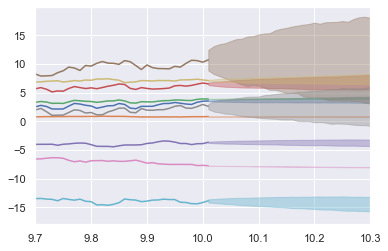

In [30]:
# Store colour palette
cp = sns.color_palette()
# Loop over dimensions of time series for plot
for i in range(0,ndatadim):
    # Cumulative sum of samples (integration) to remove differencing (remember to append training points to this!)
    fp = np.tensordot(df.values[0,i]*np.ones(1),np.ones(n_samples),axes=0) # First point
    dtd = np.tensordot(ddf.values[:,i],np.ones(n_samples),axes=0) # Differenced training data
    diff_preds = np.append(fp,np.append(dtd,pred_samps[:,i,:],axis=0),axis=0) # Append along time axis
    isamps = np.cumsum(diff_preds,axis=0)[-pred_samps.shape[0]:]
    # Compute 68% confidence
    c68l, c68u = np.quantile(isamps,[0.16,0.84],axis=1)
    # Use these to plot contours
    plt.plot(df.index,df.values[:,i],color=cp[i])
    plt.fill_between(np.arange(runtime+stepsize,future_t,stepsize),c68l,c68u,alpha=0.4,color=cp[i])
# Modify time axis for clearer display
axes = plt.gca()
axes.set_xlim([(2*runtime)-future_t,future_t])
plt.show()